In [1]:
import sys
import os 
from pathlib import Path
project_root = Path.cwd().parent# 上一级目录
os.chdir(project_root)
print("当前工作目录:", Path.cwd())

当前工作目录: C:\Users\KEYZ\Desktop\myMethod


In [2]:
from myMethod.deconvolution import Deconvolution
import pandas as pd

from myMethod.utils import pearsonr

In [3]:
data_dir = "./datas/benchmark_mob/"

In [4]:
### 单细胞数据和注释
sc_data = pd.read_csv(data_dir + "sc.csv", index_col=0)  # gene * cell
sc_data = sc_data.T
print(sc_data)
sc_annotation = pd.read_csv(data_dir + "sc_annotation.csv", index_col=0)
print(sc_annotation)
sc_data.index = sc_annotation['cellType']

                          Arc  Olig1  Nfasc  Tmem125  Tmem163  2210011C24Rik  \
10X49_5_GGACGAACTTTC-       0     19     39        7       11              6   
10X28_4_ACTTTGTGACCCTC-1    1     24     49        8       32              2   
10X49_4_GGTAACATCACG-       1      9     40        3        6              5   
10X49_4_ATGTACGACAGG-       0     17     37        3        1              2   
10X28_5_ACAGTGTGGGTATC-1    0      6     34        3       11              2   
...                       ...    ...    ...      ...      ...            ...   
10X28_4_GTTGTACTTTACCT-1    0      1      0        0        0              0   
10X49_4_AAGACTGGTGGA-       0      8      2        0        0              0   
10X28_4_TGATCACTAAGGGC-1    0      0      0        0        0              0   
10X28_4_ATTGTAGATAGCCA-1    0      0      0        0        0              0   
10X49_5_GTAACTTTCTCA-       1      0      0        0        0              0   

                          Fcnaos  Il23a

In [5]:
### 空转数据
sp_data = pd.read_csv(data_dir + "seed10my_sp.csv", index_col=0) # gene * spot
sp_data = sp_data.T
print("sp: ", sp_data)

### 空间spot的坐标
sp_location = pd.read_csv(data_dir + "spatial_location.csv", index_col=0)
print("sp location: ", sp_location)


sp:                 Arc  Olig1  Nfasc  Tmem125  Tmem163  2210011C24Rik  Fcnaos  \
16.92x9.015    0.0    4.0    1.0      2.0      1.0            0.0     0.0   
16.945x11.075  0.0    9.0    1.0      0.0      0.0            0.0     0.0   
16.97x10.118   0.0    6.0    2.0      1.0      0.0            0.0     0.0   
16.939x12.132  0.0    6.0    0.0      0.0      0.0            0.0     0.0   
16.949x13.055  1.0   10.0    1.0      4.0      3.0            0.0     0.0   
...            ...    ...    ...      ...      ...            ...     ...   
23.124x24.046  1.0    2.0    0.0      2.0      1.0            0.0     0.0   
21.01x23.944   0.0    0.0    4.0      0.0      0.0            0.0     0.0   
22.053x23.962  0.0   14.0    7.0      1.0      1.0            0.0     0.0   
27.018x20.088  1.0    7.0    1.0      1.0      0.0            0.0     0.0   
17.964x10.137  0.0   11.0    0.0      0.0      0.0            0.0     0.0   

               Il23a  Erbb3  Kndc1  ...  Kctd10  Ocln  Slc39a8  Erg  R

In [6]:
import pandas as pd
import numpy as np
from myMethod.utils import RMSE, ssim, JS, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

plt.rcParams['font.family'] = 'Times New Roman'
size = 14
plt.rcParams.update({
    'font.size': size,          # 全局字体大小，默认是10，这里加两号
    'axes.labelsize': size,     # 坐标轴标签字体大小
    'xtick.labelsize': size,    # x轴刻度字体大小
    'ytick.labelsize': size,    # y轴刻度字体大小
    'legend.fontsize': size,    # 图例字体大小
    'axes.titlesize': size      # 图标题字体大小
})

In [7]:
# 算法名
myMethodEnName = 'SAAD'

select top 5000 hvg genes to generate test ST
get celltype mean expression data mean_S
Reading dataset is done
generate simualted ST random_state is 1
Generating cell fractions using Dirichlet distribution without prior info (actually random)
RANDOM cell fractions is generated
the sparse probability is 0.8


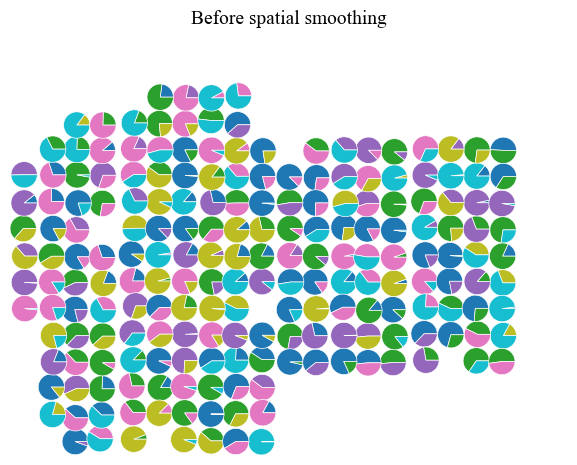

Applying spatial smoothing: knn_k=6, bandwidth=auto, spatial_strength=1.0
prop nan count: 0
construst KNN graph W


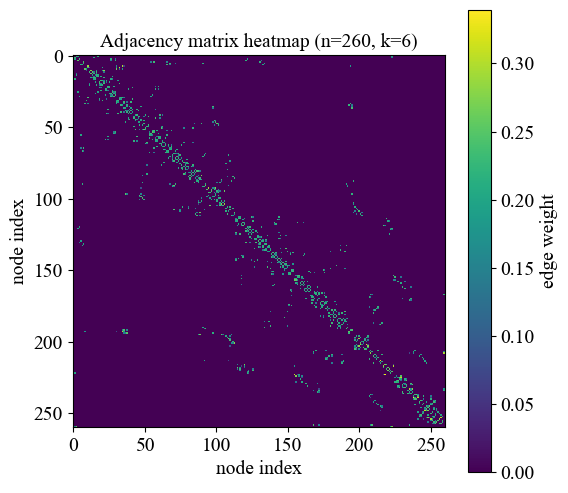

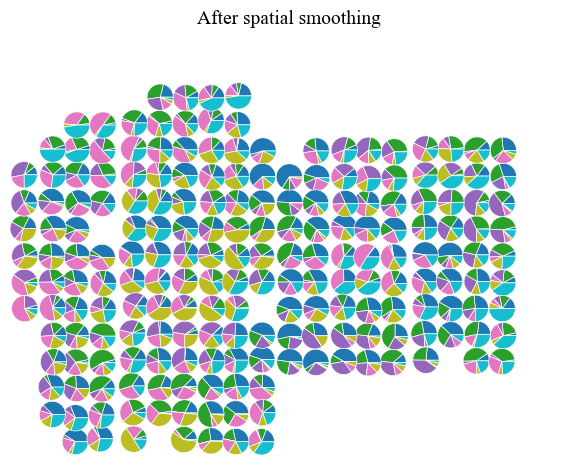

Sampling cells to compose pseudo-bulk data


260it [00:00, 9562.69it/s]

Sampling is done
Reading train data
train_data normalize_total -> log1p -> scale
Reading train data is done, shape:  (260, 5000)
Reading test data
Finding intersected genes...
test_data normalize_total -> log1p -> scale
Reading test data is done, shape:  (260, 5000)
Cutting variance threshold  0.98
Finding intersected genes after cutting variance
Intersected gene number is  4794


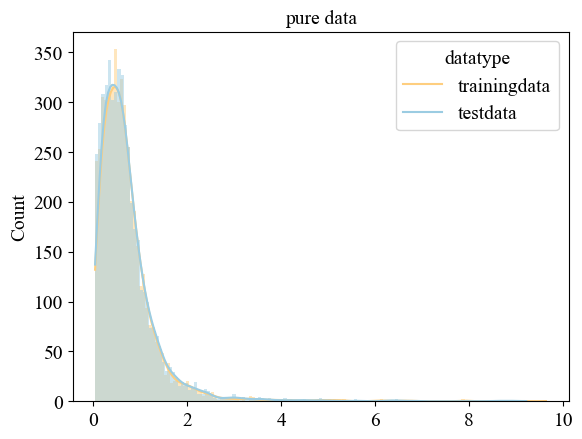

Using standard scaler...


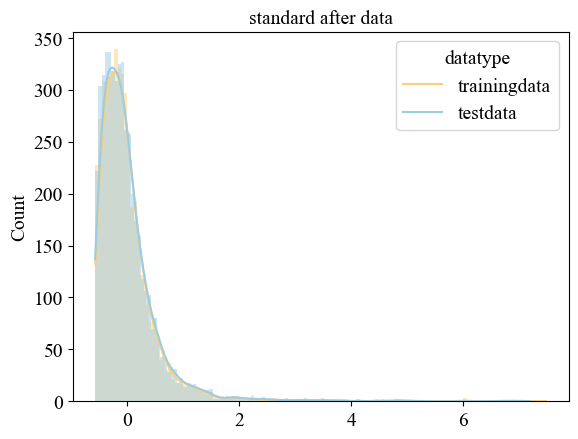

mean celltype expre mean_S,  (6, 4794)
training data shape is  (260, 4794) 
test data shape is  (260, 4794)
random seed is  1 
spatail regulation param alpha is  0.1
Start training


100%|██████████| 256/256 [00:12<00:00, 19.69it/s]


Training is done


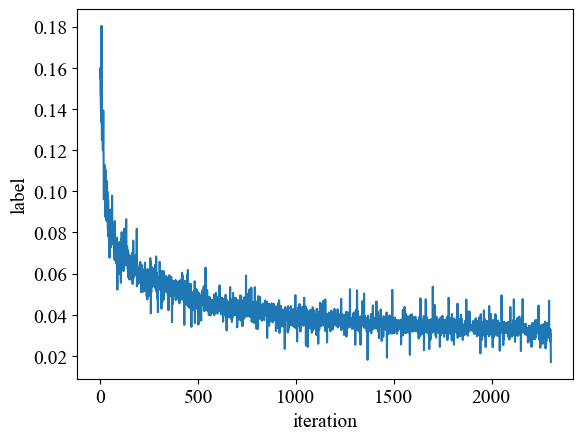

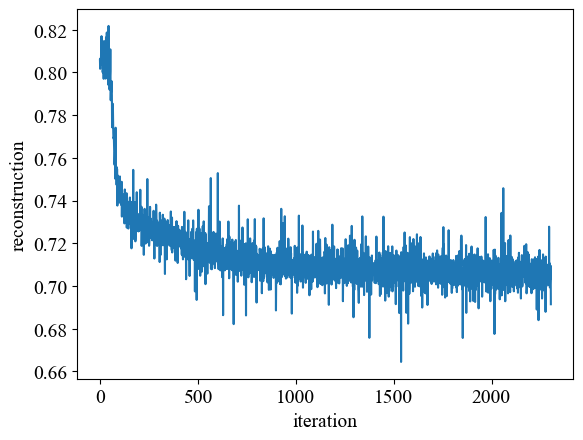

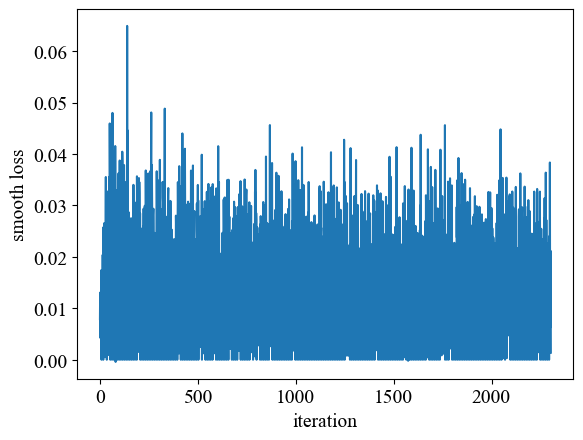

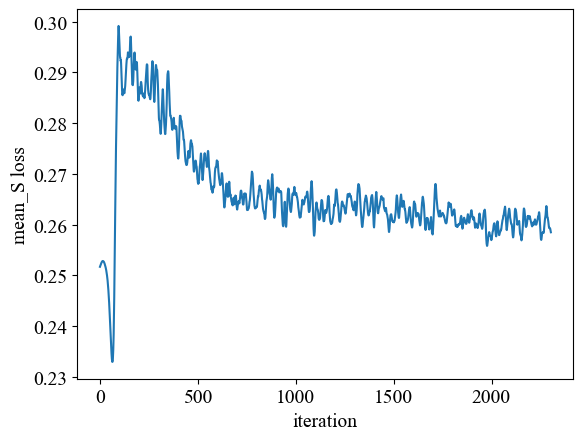

Notice that you are using parameters: mode=simulated and adaptive=True
Model is saved without defined name
Start adaptive training for all the samples, step: 300   max_iter: 5


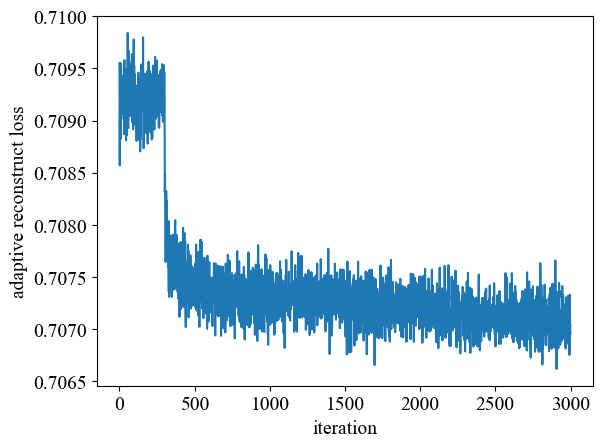

Adaptive stage is done
执行耗时: 22.64 秒


In [8]:
### 去卷积
### 去卷积
seed = 1
spatial_strength = 1  # 模拟空转时空间平滑的强度: 1
alpha = 0.1 # 空间约束权重: 0.1
scaler = 'ss'  # ss or mms
batch_size = 32 # 32 根据样本数量变化, 保证多个batch
epochs = 256 # 256

SignatureMatrix, CellFractionPrediction, elapsed_time, mean_S = \
    Deconvolution(sc_data, sp_data, coords=sp_location,
                  # 模拟空转生成的基本参数, sparse_prob: 选中比例的spot, 再选中比例的cellType置0
                  samplenum=sp_data.shape[0], d_prior=None, sparse=True, sparse_prob=0.8, spatial_strength=spatial_strength, seed=seed,
                  # 预处理参数
                  variance_threshold=0.98, scaler=scaler,
                  mode='simulated', adaptive=True, save_model_name=None,
                  # 空间约束的权重, batch_size, epochs
                  alpha=alpha, batch_size=batch_size, epochs=epochs,
                  )
print(f"执行耗时: {elapsed_time:.2f} 秒")
# model test阶段不加入relu和归一化 -> 结果存在负值
CellFractionPrediction[CellFractionPrediction < 0] = 0
CellFractionPrediction = CellFractionPrediction.div(CellFractionPrediction.sum(axis=1), axis=0)
CellFractionPrediction.to_csv("myMethod.csv")

In [10]:
### 结果评估
ground_truth = pd.read_csv(data_dir + "seed10my_ground_truth.csv", index_col=0)

PCC = pearsonr(CellFractionPrediction, ground_truth)
print("PCC: ", PCC)

RCTD = pd.read_csv(data_dir + "result_seed10/RCTD_res.csv", index_col=0)
RCTDPCC = pearsonr(RCTD, ground_truth)
print("RCTD PCC : ", RCTDPCC)

PCC:           Astrocytes  Ependymal    Immune   Neurons    Oligos  Vascular
Pearson    0.870827   0.914278  0.933862  0.855093  0.841822  0.905123
RCTD PCC :           Astrocytes  Ependymal   Immune   Neurons    Oligos  Vascular
Pearson    0.809896   0.838939  0.89256  0.824224  0.816196  0.851682


var_meanS [ 1.11384252  1.50110772  4.68074817  0.1891731  14.10739187  1.73118385]
var_SignatureMatrix Astrocytes    0.454454
Ependymal     0.841850
Immune        0.499180
Neurons       0.348142
Oligos        0.751987
Vascular      0.412440
dtype: float32


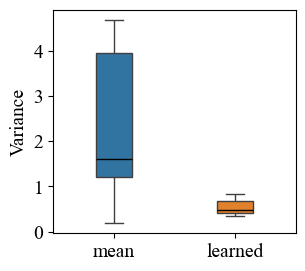

In [30]:
var_meanS = np.var(mean_S, axis=1, ddof=1)
print('var_meanS', var_meanS)
var_SignatureMatrix = np.var(SignatureMatrix, axis=1, ddof=1)
print('var_SignatureMatrix', var_SignatureMatrix)
# 绘制箱图
df = pd.DataFrame({
    'mean': var_meanS,
    'learned': var_SignatureMatrix
})

plt.figure(figsize=(3.135, 2.9))
sns.boxplot(data=df, width=0.3, showfliers=False, medianprops=dict(color="black"))
plt.ylabel('Variance')
plt.savefig(data_dir + "figure/var_dif.pdf", bbox_inches='tight')

In [9]:
import re
myMethod = CellFractionPrediction

ground_truth = pd.read_csv(data_dir +"seed10my_ground_truth.csv", index_col=0)
ground_truth = ground_truth.div(ground_truth.sum(axis=1), axis='rows')
print(ground_truth)

DSTG_column_label = ["Oligos", "Neurons", "Vascular", "Astrocytes", "Ependymal", "Immune"]

# SPOTlight
spotlight_res = pd.read_csv(data_dir +"result_seed10/SPOTlight_res.csv", index_col=0)
spotlight_res = spotlight_res.div(spotlight_res.sum(axis=1), axis='rows')
spotlight_res.index = ground_truth.index.values
# RCTD
RCTD_res = pd.read_csv(data_dir + "result_seed10/RCTD_res.csv", index_col=0)
RCTD_res = RCTD_res.div(RCTD_res.sum(axis=1), axis='rows')
RCTD_res.index = ground_truth.index.values
# Cell2lcoation
cell2location_res = pd.read_csv(data_dir +"result_seed10/cell2location_res.csv", index_col=0)
cell2location_res.columns = [re.sub('q05cell_abundance_w_sf_', '', r) for r in cell2location_res.columns]
cell2location_res = cell2location_res.div(cell2location_res.sum(axis=1), axis='rows') # 按spot归一化
cell2location_res.index = ground_truth.index.values
# Redeconve
Redeconve_res = pd.read_csv(data_dir +"result_seed10/Redeconve_res.csv", index_col=0)
Redeconve_res = Redeconve_res.div(Redeconve_res.sum(axis=1), axis='rows') # 按spot归一化
Redeconve_res.index = ground_truth.index.values
# CARD
CARD_res = pd.read_csv(data_dir +"result_seed10/CARD_res.csv", index_col=0)
CARD_res = CARD_res.div(CARD_res.sum(axis=1), axis='rows') # 按spot归一化
CARD_res.index = ground_truth.index.values
# DestVI
DestVI_res = pd.read_csv(data_dir +"result_seed10/DestVI_res.csv", index_col=0)
DestVI_res = DestVI_res.div(DestVI_res.sum(axis=1), axis='rows') # 按spot归一化
DestVI_res.index = DestVI_res.index.values
# SpatialDWLS
SpatialDWLS_res = pd.read_csv(data_dir +"result_seed10/SpatialDWLS_res.csv", index_col=0).iloc[:,1:]
SpatialDWLS_res = SpatialDWLS_res.div(SpatialDWLS_res.sum(axis=1), axis='rows') # 按spot归一化
SpatialDWLS_res.index = ground_truth.index.values
SpatialDWLS_res = SpatialDWLS_res.replace([np.inf, -np.inf], np.nan).fillna(0)
# DSTG
DSTG_res = pd.read_csv(data_dir +"result_seed10/DSTG_res.csv", header=None)
DSTG_res.columns = DSTG_column_label
DSTG_res = DSTG_res.div(DSTG_res.sum(axis=1), axis='rows') # 按spot归一化
DSTG_res.index = ground_truth.index.values

               Astrocytes  Ependymal    Immune   Neurons    Oligos  Vascular
16.92x9.015      0.000000   0.166667  0.166667  0.333333  0.333333  0.000000
16.945x11.075    0.142857   0.142857  0.142857  0.142857  0.142857  0.285714
16.97x10.118     0.125000   0.125000  0.250000  0.125000  0.125000  0.250000
16.939x12.132    0.500000   0.000000  0.000000  0.125000  0.125000  0.250000
16.949x13.055    0.428571   0.142857  0.000000  0.285714  0.142857  0.000000
...                   ...        ...       ...       ...       ...       ...
23.124x24.046    0.000000   0.285714  0.142857  0.142857  0.285714  0.142857
21.01x23.944     0.333333   0.166667  0.166667  0.166667  0.166667  0.000000
22.053x23.962    0.142857   0.142857  0.142857  0.142857  0.285714  0.142857
27.018x20.088    0.142857   0.142857  0.142857  0.142857  0.142857  0.285714
17.964x10.137    0.000000   0.285714  0.142857  0.142857  0.142857  0.285714

[260 rows x 6 columns]


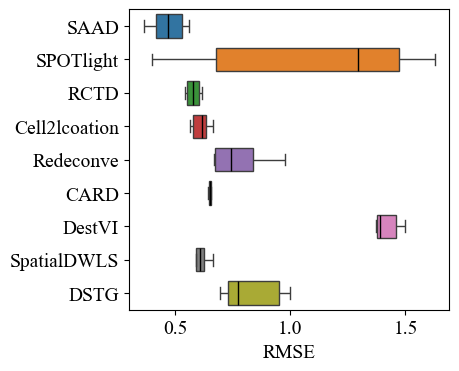

In [11]:
## RMSE
my_rmse = RMSE(ground_truth, myMethod)
# SPOTlight
spotlight_rmse = RMSE(ground_truth, spotlight_res)
# RCTD
RCTD_rmse = RMSE(ground_truth, RCTD_res)
# Cell2lcoation
cell2location_rmse= RMSE(ground_truth, cell2location_res)
# Redeconve
Redeconve_rmse = RMSE(ground_truth, Redeconve_res)
# CARD
CARD_rmse = RMSE(ground_truth, CARD_res)
# DestVI
DestVI_rmse = RMSE(ground_truth, DestVI_res)
# SpatialDWLS
SpatialDWLS_rmse = RMSE(ground_truth, SpatialDWLS_res)
# DSTG
DSTG_rmse = RMSE(ground_truth, DSTG_res)

# show
plt.figure(figsize=(4.135, 3.9))
rmse_data = pd.DataFrame({myMethodEnName:my_rmse.values[0],
                          'SPOTlight':spotlight_rmse.values[0],
                         'RCTD':RCTD_rmse.values[0], 'Cell2lcoation':cell2location_rmse.values[0],
                          'Redeconve':Redeconve_rmse.values[0],
                          "CARD":CARD_rmse.values[0],
                          "DestVI":DestVI_rmse.values[0], "SpatialDWLS":SpatialDWLS_rmse.values[0],
                          "DSTG":DSTG_rmse.values[0]})
sns.boxplot(data=rmse_data, orient='h', width=0.7, showfliers=False, medianprops=dict(color="black"))
plt.xlabel('RMSE')
plt.savefig(data_dir + "figure/RMSE.pdf", bbox_inches='tight')

In [15]:
print(my_rmse)
print(RCTD_rmse)

      Astrocytes  Ependymal    Immune   Neurons    Oligos  Vascular
RMSE    0.508278   0.414059  0.363699  0.538343  0.562455  0.435608
      Astrocytes  Ependymal    Immune   Neurons    Oligos  Vascular
RMSE     0.61661   0.567558  0.463552  0.592918  0.606307  0.544644


          SAAD  SPOTlight      RCTD  Cell2lcoation  Redeconve      CARD  \
mean  0.470407    1.10459  0.565265       0.586774   0.775382  0.633062   
std   0.077840    0.52253  0.056323       0.088412   0.124924  0.073912   

        DestVI  SpatialDWLS      DSTG  
mean  1.385839     0.602087  0.929076  
std   0.114295     0.050686  0.348311  


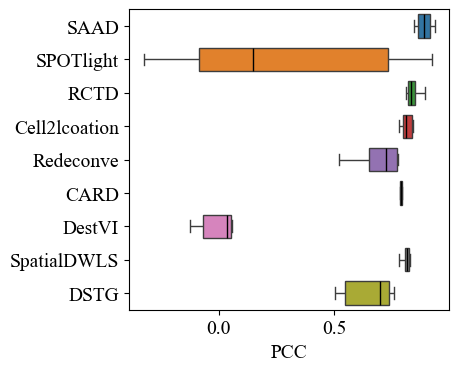

In [15]:
## PCC
my_pcc = pearsonr(ground_truth, myMethod)
# SPOTlight
spotlight_pcc = pearsonr(ground_truth, spotlight_res)
# RCTD
RCTD_pcc = pearsonr(ground_truth, RCTD_res)
# Cell2lcoation
cell2location_pcc = pearsonr(ground_truth, cell2location_res)
# Redeconve
Redeconve_pcc  = pearsonr(ground_truth, Redeconve_res)
# CARD
CARD_pcc = pearsonr(ground_truth, CARD_res)
# DestVI
DestVI_pcc = pearsonr(ground_truth, DestVI_res)
# SpatialDWLS
SpatialDWLS_pcc = pearsonr(ground_truth, SpatialDWLS_res)
# DSTG
DSTG_pcc = pearsonr(ground_truth, DSTG_res)

# show
plt.figure(figsize=(4.135, 3.9))
pcc_data = pd.DataFrame({myMethodEnName:my_pcc.values[0],
                         'SPOTlight':spotlight_pcc.values[0],
                         'RCTD':RCTD_pcc.values[0], 'Cell2lcoation':cell2location_pcc.values[0],
                          'Redeconve':Redeconve_pcc.values[0],
                         "CARD":CARD_pcc.values[0],
                          "DestVI":DestVI_pcc.values[0], "SpatialDWLS":SpatialDWLS_pcc.values[0],
                         "DSTG":DSTG_pcc.values[0]})
sns.boxplot(data=pcc_data, orient='h', width=0.7, showfliers=False,medianprops=dict(color="black"))
plt.xlabel('PCC')
plt.savefig(data_dir + "figure/PCC.pdf", bbox_inches='tight')

In [17]:
print(my_pcc)
print(RCTD_pcc)

         Astrocytes  Ependymal    Immune   Neurons    Oligos  Vascular
Pearson    0.870827   0.914278  0.933862  0.855093  0.841822  0.905123
         Astrocytes  Ependymal   Immune   Neurons    Oligos  Vascular
Pearson    0.809896   0.838939  0.89256  0.824224  0.816196  0.851682


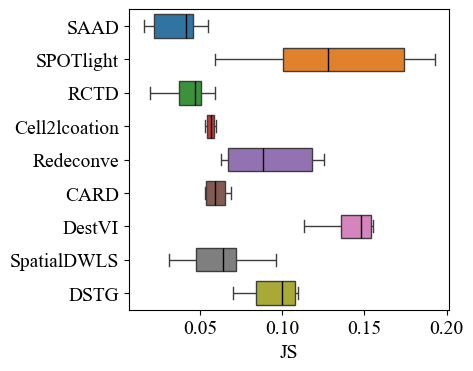

In [16]:
## JS
my_JS = JS(ground_truth, myMethod)
# SPOTlight
spotlight_JS = JS(ground_truth, spotlight_res)
# RCTD
RCTD_JS = JS(ground_truth, RCTD_res)
# Cell2lcoation
cell2location_JS = JS(ground_truth, cell2location_res)
# Redeconve
Redeconve_JS = JS(ground_truth, Redeconve_res)
# CARD
CARD_JS = JS(ground_truth, CARD_res)
# DestVI
DestVI_JS = JS(ground_truth, DestVI_res)
# SpatialDWLS
SpatialDWLS_JS = JS(ground_truth, SpatialDWLS_res)
# DSTG
DSTG_JS = JS(ground_truth, DSTG_res)

# show
plt.figure(figsize=(4.135, 3.9))
JS_data = pd.DataFrame({myMethodEnName:my_JS.values[0],
                        'SPOTlight':spotlight_JS.values[0],
                         'RCTD':RCTD_JS.values[0], 'Cell2lcoation':cell2location_JS.values[0],
                          'Redeconve':Redeconve_JS.values[0],
                        "CARD":CARD_JS.values[0],
                          "DestVI":DestVI_JS.values[0], "SpatialDWLS":SpatialDWLS_JS.values[0],
                        "DSTG":DSTG_JS.values[0]})
sns.boxplot(data=JS_data, orient='h', width=0.7, showfliers=False,medianprops=dict(color="black"))
plt.xlabel('JS')
plt.savefig(data_dir + "figure/JS.pdf", bbox_inches='tight')

In [19]:
print(my_JS)
print(RCTD_JS)

    Astrocytes  Ependymal    Immune   Neurons    Oligos  Vascular
JS    0.046065   0.015695  0.016709  0.045473  0.054801  0.038109
    Astrocytes  Ependymal    Immune   Neurons    Oligos  Vascular
JS    0.051392   0.034264  0.019835  0.047666  0.058903  0.045964


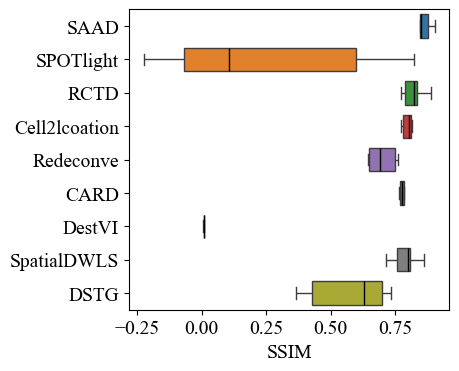

In [17]:
## SSIM
my_ssim = ssim(ground_truth, myMethod)
# SPOTlight
spotlight_ssim = ssim(ground_truth, spotlight_res)
# RCTD
RCTD_ssim = ssim(ground_truth, RCTD_res)
# Cell2lcoation
cell2location_ssim= ssim(ground_truth, cell2location_res)
# Redeconve
Redeconve_ssim = ssim(ground_truth, Redeconve_res)
# CARD
CARD_ssim = ssim(ground_truth, CARD_res)
# DestVI
DestVI_ssim = ssim(ground_truth, DestVI_res)
# SpatialDWLS
SpatialDWLS_ssim = ssim(ground_truth, SpatialDWLS_res)
# DSTG
DSTG_ssim = ssim(ground_truth, DSTG_res)
# show
plt.figure(figsize=(4.135, 3.9))
ssim_data = pd.DataFrame({myMethodEnName:my_ssim.values[0],
                          'SPOTlight':spotlight_ssim.values[0],
                         'RCTD':RCTD_ssim.values[0], 'Cell2lcoation':cell2location_ssim.values[0],
                          'Redeconve':Redeconve_ssim.values[0],
                          "CARD":CARD_ssim.values[0],
                          "DestVI":DestVI_ssim.values[0], "SpatialDWLS":SpatialDWLS_ssim.values[0],
                          "DSTG":DSTG_ssim.values[0]})
sns.boxplot(data=ssim_data, orient='h', width=0.7, showfliers= False,medianprops=dict(color="black"))
plt.xlabel('SSIM')
plt.savefig(data_dir + "figure/SSIM.pdf", bbox_inches='tight')

In [21]:
print(my_ssim)
print(RCTD_ssim)

      Astrocytes  Ependymal    Immune   Neurons    Oligos  Vascular
SSIM    0.850338   0.884302  0.904175  0.847133  0.783077  0.854007
      Astrocytes  Ependymal    Immune   Neurons    Oligos  Vascular
SSIM    0.779659   0.831965  0.888979  0.810839  0.774249  0.838296


In [ ]:
## 均值和方差统计

In [26]:
from IPython.display import display
print("=== PCC Stats ===")
pcc_stats = pd.DataFrame([pcc_data.mean(), pcc_data.std()],
                          index=['mean', 'std'])
display(pcc_stats)

print("=== SSIM Stats ===")
ssim_stats = pd.DataFrame([ssim_data.mean(),ssim_data.std()],
                          index=['mean', 'std'])
display(ssim_stats)

print("=== JS Stats ===")
JS_stats = pd.DataFrame([JS_data.mean(), JS_data.std()],
                          index=['mean', 'std'])
display(JS_stats)

print("=== RMSE Stats ===")
rmse_stats = pd.DataFrame([rmse_data.mean(), rmse_data.std()],
                          index=['mean', 'std'])
display(rmse_stats)

=== PCC Stats ===


,SAAD,SPOTlight,RCTD,Cell2lcoation,Redeconve,CARD,DestVI,SpatialDWLS,DSTG
mean,0.886834,0.276175,0.838916,0.824591,0.692889,0.79734,0.034282,0.817675,0.517859
std,0.036302,0.522369,0.030380,0.047407,0.101564,0.04337,0.152963,0.029626,0.405399


=== SSIM Stats ===


,SAAD,SPOTlight,RCTD,Cell2lcoation,Redeconve,CARD,DestVI,SpatialDWLS,DSTG
mean,0.853839,0.241233,0.820665,0.796967,0.611724,0.787716,0.010372,0.787762,0.467359
std,0.041295,0.437844,0.042516,0.062924,0.246064,0.047608,0.004781,0.053059,0.385578


=== JS Stats ===


,SAAD,SPOTlight,RCTD,Cell2lcoation,Redeconve,CARD,DestVI,SpatialDWLS,DSTG
mean,0.036142,0.131513,0.043004,0.051230,0.133181,0.055418,0.150602,0.061939,0.110183
std,0.016330,0.052402,0.013906,0.014644,0.119422,0.015310,0.031600,0.023024,0.047187


=== RMSE Stats ===


,SAAD,SPOTlight,RCTD,Cell2lcoation,Redeconve,CARD,DestVI,SpatialDWLS,DSTG
mean,0.470407,1.10459,0.565265,0.586774,0.775382,0.633062,1.385839,0.602087,0.929076
std,0.077840,0.52253,0.056323,0.088412,0.124924,0.073912,0.114295,0.050686,0.348311


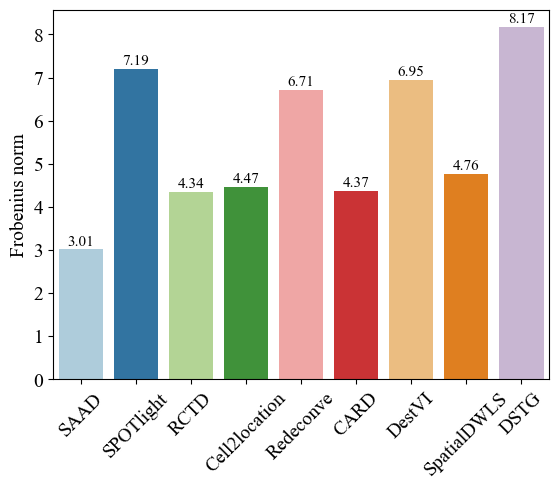

In [27]:
myMethod_f = np.linalg.norm(myMethod - ground_truth, 'fro')
spotlight_f = np.linalg.norm(spotlight_res - ground_truth, 'fro')
RCTD_f = np.linalg.norm(RCTD_res - ground_truth, 'fro')
cell2location_f = np.linalg.norm(cell2location_res - ground_truth, 'fro')
Redeconve_f= np.linalg.norm(Redeconve_res - ground_truth, 'fro')
CARD_f = np.linalg.norm(CARD_res - ground_truth, 'fro')
DestVI_f = np.linalg.norm(DestVI_res - ground_truth, 'fro')
SpatialDWLS_f = np.linalg.norm(SpatialDWLS_res - ground_truth, 'fro')
DSTG_f = np.linalg.norm(DSTG_res - ground_truth, 'fro')

methods = {
    myMethodEnName: myMethod_f,
    "SPOTlight": spotlight_f,
    "RCTD": RCTD_f,
    "Cell2location": cell2location_f,
    "Redeconve": Redeconve_f,
    "CARD": CARD_f,
    "DestVI": DestVI_f,
    "SpatialDWLS": SpatialDWLS_f,
    "DSTG": DSTG_f,
}
data = pd.DataFrame([methods])
ax = sns.barplot(data=data,palette=sns.color_palette("Paired"))
ax.set_xticklabels(labels=data.columns,rotation=45)
plt.ylabel("Frobenius norm")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=0.8, fontsize=11)
plt.savefig(data_dir + "figure/Frobenius.pdf", bbox_inches='tight')

In [23]:
### 显著性

In [24]:
"""PCC"""
from scipy.stats import ttest_rel
import pandas as pd

# 你的 DataFrame
df = pcc_data

target = myMethodEnName
methods = [col for col in df.columns if col != target]

results = []

for method in methods:
    t_stat, p_two_sided = ttest_rel(df[target], df[method])

    # 单边右尾检验（是否显著更大）
    p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - p_two_sided / 2
    
    # 左尾检验：是否 < other
    # p_left = p_two_sided / 2 if t_stat < 0 else 1 - p_two_sided / 2
    
    if p_one_sided < 0.005:
        p_label = '<0.005'
    elif p_one_sided < 0.05:
        p_label = '<0.05'
    elif p_one_sided < 0.5:
        p_label = '<0.5'
    else:
        p_label = '>=0.5'
    
    results.append({
        'vs': method,
        'p (one-sided)': round(p_one_sided, 4),
        'Significance': p_label
    })

# 输出成表格
result_df = pd.DataFrame(results)
print(result_df)


              vs  p (one-sided) Significance
0      SPOTlight         0.0144        <0.05
1           RCTD         0.0008       <0.005
2  Cell2lcoation         0.0034       <0.005
3      Redeconve         0.0017       <0.005
4           CARD         0.0022       <0.005
5         DestVI         0.0000       <0.005
6    SpatialDWLS         0.0001       <0.005
7           DSTG         0.0413        <0.05


In [25]:
"""SSIM"""
from scipy.stats import ttest_rel
import pandas as pd

# 你的 DataFrame
df = ssim_data

target = myMethodEnName
methods = [col for col in df.columns if col != target]

results = []

for method in methods:
    t_stat, p_two_sided = ttest_rel(df[target], df[method])

    # 单边右尾检验（是否显著更大）
    p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - p_two_sided / 2
    
    # 左尾检验：是否  < other
    # p_left = p_two_sided / 2 if t_stat < 0 else 1 - p_two_sided / 2
    
    if p_one_sided < 0.005:
        p_label = '<0.005'
    elif p_one_sided < 0.05:
        p_label = '<0.05'
    elif p_one_sided < 0.5:
        p_label = '<0.5'
    else:
        p_label = '>=0.5'
    
    results.append({
        'vs': method,
        'p (one-sided)': round(p_one_sided, 4),
        'Significance': p_label
    })

# 输出成表格
result_df = pd.DataFrame(results)
print(result_df)


              vs  p (one-sided) Significance
0      SPOTlight         0.0076        <0.05
1           RCTD         0.0106        <0.05
2  Cell2lcoation         0.0528         <0.5
3      Redeconve         0.0296        <0.05
4           CARD         0.0106        <0.05
5         DestVI         0.0000       <0.005
6    SpatialDWLS         0.0007       <0.005
7           DSTG         0.0331        <0.05


In [26]:
"""JS"""
from scipy.stats import ttest_rel
import pandas as pd

# 你的 DataFrame
df = JS_data

target = myMethodEnName
methods = [col for col in df.columns if col != target]

results = []

for method in methods:
    t_stat, p_two_sided = ttest_rel(df[target], df[method])

    # 单边右尾检验（是否显著更大）
    # p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - p_two_sided / 2
    
    # 左尾检验：是否  < other
    p_one_sided = p_two_sided / 2 if t_stat < 0 else 1 - p_two_sided / 2
    
    if p_one_sided < 0.005:
        p_label = '<0.005'
    elif p_one_sided < 0.05:
        p_label = '<0.05'
    elif p_one_sided < 0.5:
        p_label = '<0.5'
    else:
        p_label = '>=0.5'
    
    results.append({
        'vs': method,
        'p (one-sided)': round(p_one_sided, 4),
        'Significance': p_label
    })

# 输出成表格
result_df = pd.DataFrame(results)
print(result_df)


              vs  p (one-sided) Significance
0      SPOTlight         0.0009       <0.005
1           RCTD         0.0196        <0.05
2  Cell2lcoation         0.0211        <0.05
3      Redeconve         0.0460        <0.05
4           CARD         0.0059        <0.05
5         DestVI         0.0002       <0.005
6    SpatialDWLS         0.0007       <0.005
7           DSTG         0.0129        <0.05


In [27]:
"""RMSE"""
from scipy.stats import ttest_rel
import pandas as pd

# 你的 DataFrame
df = rmse_data

target = myMethodEnName
methods = [col for col in df.columns if col != target]

results = []

for method in methods:
    t_stat, p_two_sided = ttest_rel(df[target], df[method])

    # 单边右尾检验（是否显著更大）
    # p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - p_two_sided / 2
    
    # 左尾检验：是否 < other
    p_one_sided = p_two_sided / 2 if t_stat < 0 else 1 - p_two_sided / 2
    
    if p_one_sided < 0.005:
        p_label = '<0.005'
    elif p_one_sided < 0.05:
        p_label = '<0.05'
    elif p_one_sided < 0.5:
        p_label = '<0.5'
    else:
        p_label = '>=0.5'
    
    results.append({
        'vs': method,
        'p (one-sided)': round(p_one_sided, 4),
        'Significance': p_label
    })

# 输出成表格
result_df = pd.DataFrame(results)
print(result_df)


              vs  p (one-sided) Significance
0      SPOTlight         0.0098        <0.05
1           RCTD         0.0011       <0.005
2  Cell2lcoation         0.0031       <0.005
3      Redeconve         0.0006       <0.005
4           CARD         0.0019       <0.005
5         DestVI         0.0000       <0.005
6    SpatialDWLS         0.0003       <0.005
7           DSTG         0.0151        <0.05


In [28]:
## 空间消融实验 ablation_on_seed10.py

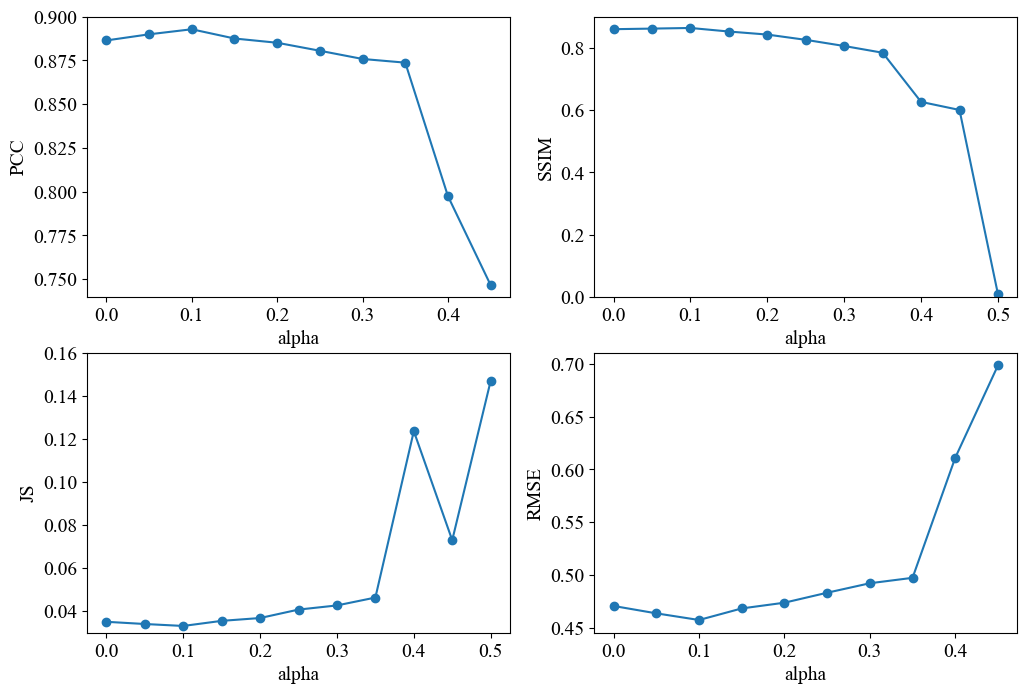

In [28]:
results = pd.read_csv(data_dir + "ablation_summary.csv")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

axes[0].plot(results['alpha'], results['PCC'], marker='o')
axes[0].set_xlabel('alpha'); axes[0].set_ylabel('PCC')
axes[0].set_ylim(0.74,0.9)

axes[1].plot(results['alpha'], results['SSIM'], marker='o')
axes[1].set_xlabel('alpha'); axes[1].set_ylabel('SSIM')
axes[1].set_ylim(0,0.9)

axes[2].plot(results['alpha'], results['JS'], marker='o')
axes[2].set_xlabel('alpha'); axes[2].set_ylabel('JS')
axes[2].set_ylim(0.03,0.16)

axes[3].plot(results['alpha'], results['RMSE'], marker='o')
axes[3].set_xlabel('alpha'); axes[3].set_ylabel('RMSE')

plt.savefig(data_dir + "figure/ablation_alpha.pdf",  bbox_inches='tight')


In [29]:
display(results[['alpha', 'PCC', 'SSIM', 'JS', 'RMSE']])

,alpha,PCC,SSIM,JS,RMSE
0,0.00,0.886449,0.859911,0.035072,0.470673
1,0.05,0.889948,0.861827,0.034047,0.463694
2,0.10,0.892834,0.863839,0.033142,0.457407
3,0.15,0.887555,0.852414,0.035507,0.468355
4,0.20,0.885124,0.842626,0.036822,0.473780
5,0.25,0.880556,0.825672,0.040740,0.483215
6,0.30,0.875859,0.805886,0.042669,0.492182
7,0.35,0.873754,0.784241,0.046329,0.497324
8,0.40,0.797438,0.626247,0.123579,0.610962
9,0.45,0.746603,0.600320,0.072954,0.698341
